In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import ipywidgets as w
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from scipy.stats import skew
plt.rcParams.update({'font.size': 22})

In [2]:
from typhon.retrieval.qrnn import set_backend, QRNN
set_backend("pytorch")

quantiles = np.array([0.002, 0.03, 0.16, 0.5, 0.84, 0.97, 0.998])


batchSize = 128


convergence_epoch = 6
maximum_epoch = 100


In [3]:
target = 'I2V'
inChannels = np.array(['I1V', 'I2V', 'I3V',  'I5V', 'I6V', 'I7V', 'I8V', 'I9V', 'I10V', 'I11V', 'I11H'])
itarget = np.argwhere(inChannels == target)[0][0]
inChannels = np.array([target, 'I5V' , 'I6V', 'I7V', 'I8V', 'I9V', 'I10V', 'I11V', 'I11H'])

In [4]:
def quantile_loss(y_pre, y, quantiles):
    loss = 0
    for i in range(len(quantiles)):
        dy = y_pre[:, 3] - y
        qs = quantiles[i]
        l = np.where(dy >= 0.0, 
                        (1.0 - qs) * abs(dy),
                        (qs) * abs(dy))
        loss += l.mean()
    return loss.mean()  

### read data

In [5]:
from torch.utils.data import DataLoader, random_split
from ici import iciData


itarget, = np.argwhere(inChannels == target)[0]
data = iciData("TB_ICI_train.nc", 
               inChannels, target, 
               batch_size = batchSize)   
inputs = len(inChannels)

n = len(data)
n_train = int(0.9 * n)
n_val = n - n_train
training_data, validation_data = random_split(data, [n_train, n_val])
results = []


In [6]:
def train(depth, width, batchSize, convergence_epoch, maximum_epoch, training_data, validation_data):
        qrnn = QRNN(inputs, quantiles, (depth, width , "relu"))
        for lr in [ 0.01, 0.001, 0.0001]:
            print ("NEW LEARNING RATE")
            results = qrnn.train(
                training_data,
                validation_data,
                batch_size=batchSize,
                momentum = 0,
                sigma_noise=None,
                initial_learning_rate= lr ,
                maximum_epochs=maximum_epoch,
                convergence_epochs= convergence_epoch,    
                gpu=True)

        return results, qrnn

### grid search for depth and width

In [7]:
nn_depths  = [2, 3, 4 ]
nn_widths  = [ 8, 16, 32, 64, 128,  256, 512]

NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE



NEW LEARNING RATE


KeyboardInterrupt: 

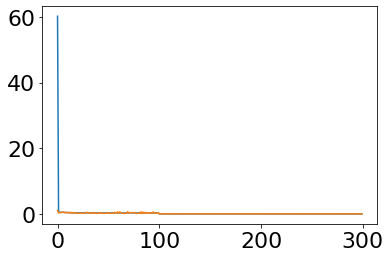

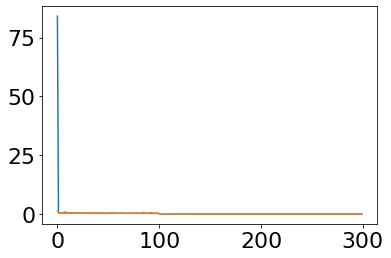

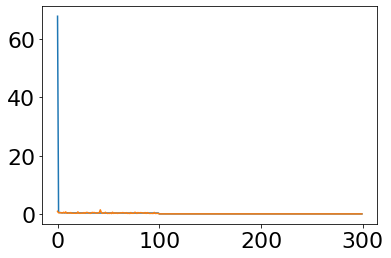

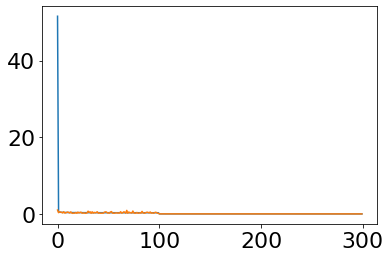

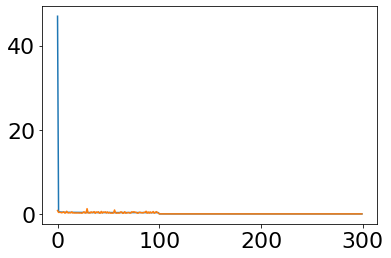

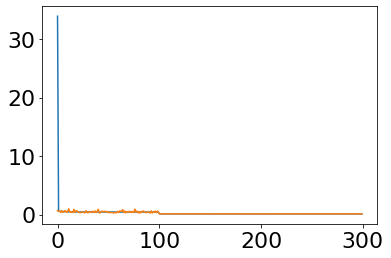

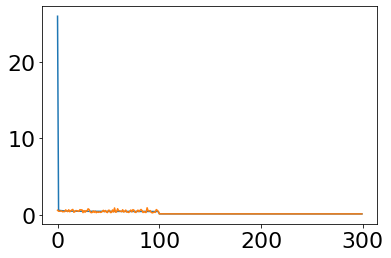

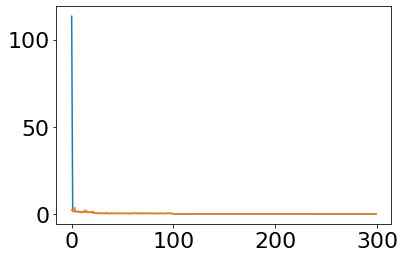

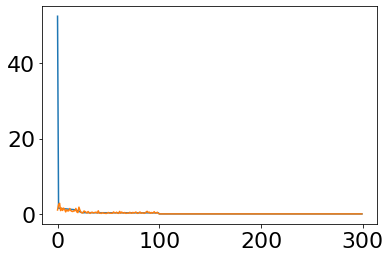

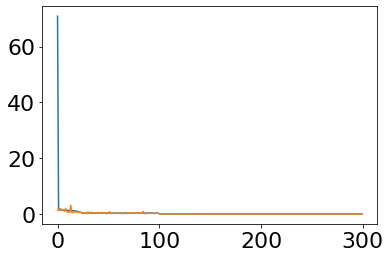

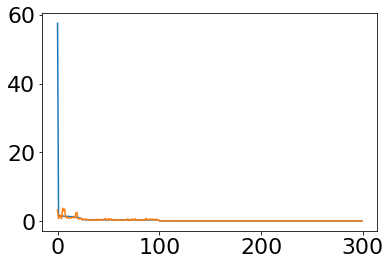

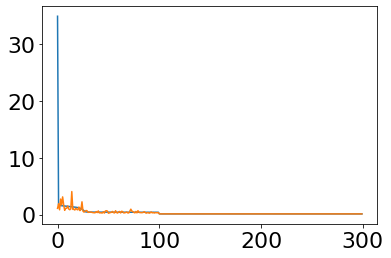

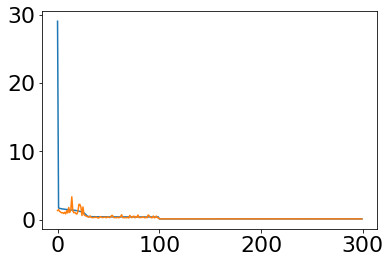

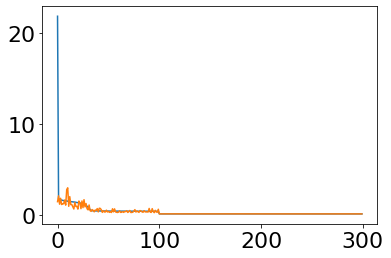

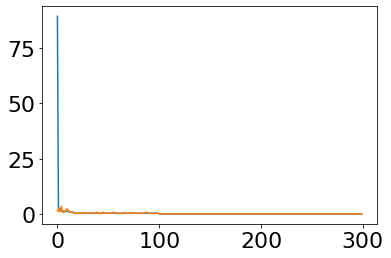

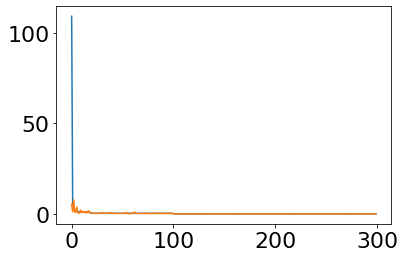

In [8]:
for nn_dep in nn_depths:
    for nn_wid in nn_widths:       
        results, qrnn = train(nn_dep, nn_wid, batchSize, convergence_epoch, maximum_epoch, training_data, validation_data)
        fig, ax = plt.subplots(1, 1)
        ax.plot(results['training_errors'])
        ax.plot(results['validation_errors'])
        qrnn.save('qrnn_ici_depth-%s_width-%s_%s.nc'%(str(nn_dep),str(nn_wid),target))

In [ ]:

test_data = iciData("TB_ICI_train.nc", 
               inChannels, target, 
               batch_size = batchSize)  
n = len(data)
n_train = int(0.9 * n)
n_val = n - n_train
training_data, validation_data = random_split(data, [n_train, n_val])



In [ ]:
y_pre = []
y = []
y_prior = []
y_pos_mean = []
x_in = []

nbatch = validation_data.__len__()
print (nbatch)
for i in range(nbatch):
    
    xx, yy = validation_data.__getitem__(i)
    
    x = xx.detach().numpy() 

    y_prior.append((x * data.std) + data.mean)
#    y_prior.append((x[:, 0]))

#    y_pre.append(qrnn.predict(x)) 
#    y_pos_mean.append((qrnn.posterior_mean(x)))
       
    y.append(yy.detach().numpy())
    x_in.append(x)
x = np.concatenate(x_in, axis = 0) 
y = np.concatenate(y, axis= 0)

In [ ]:
scores = np.empty([len(nn_depths), len(nn_widths)])
loss = np.empty([len(nn_depths), len(nn_widths)])
quantiles1 = np.array([0.5])
for i, nn_depth in enumerate(nn_depths):
    for j, nn_width in enumerate(nn_widths):
        filename = 'RESULTS/gridsearch_results/iter2/qrnn_ici_depth-%s_width-%s_%s.nc'%(str(nn_depth),str(nn_width),target)
        print(filename)
        qrnn = QRNN.load(filename)

        y_pre = qrnn.predict(x)
        y0 = y
#        scores = qrnn.crps(y_pre, y, quantiles)
        scores[i,j] = np.mean(qrnn.crps(y_pre, y0, quantiles))
    
        loss[i,j] = quantile_loss(y_pre, y0, quantiles)


In [ ]:

#plt.rc('xtick', labelsize='x-small')
#plt.rc('ytick', labelsize='x-small')
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [18, 8])
plt.subplots_adjust(wspace = .3)
#fig.tight_layout()
color = ['r', 'b', 'k']
for i in range(len(nn_depths)):
    ax1.plot(scores[i, :], linewidth = 2.5, c = color[i])
ax1.set_xlabel("Layer Width")
ax1.set_ylabel("CRPS")
ax1.set_xticks(np.arange(len(nn_widths)))
ax1.set_xticklabels(nn_widths)
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.yaxis.set_minor_locator(MultipleLocator(0.2))
ax1.grid(which = 'both', alpha = 0.2)
#ax.set_yscale('log')
#ax1.legend(["$n_h$ = 2", "$n_h$ = 3", "$n_h$ = 4", "$n_h$ = 4"], prop={'size': 20})

for i in range(len(nn_depths)):
    ax2.plot(loss[i, :], linewidth = 2.5, c = color [i])
ax2.set_xlabel("Layer Width")
ax2.set_ylabel("Mean quantile loss")
ax2.set_xticks(np.arange(len(nn_widths)))
ax2.set_xticklabels(nn_widths)

ax2.yaxis.set_minor_locator(MultipleLocator(1.5))
ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax2.grid(which = 'both', alpha = 0.2)
#ax.set_yscale('log')
(ax2.legend(["$n_h$ = 2", "$n_h$ = 3", "$n_h$ = 4", "$n_h$ = 4"],
            prop={'size': 22}, frameon = False, bbox_to_anchor=(0.4, -0.12),ncol=3))

fig.savefig("Figures/CRPS.pdf", bbox_inches = 'tight')
  



In [ ]:
f
